Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


C:\Users\Jayesh\AppData\Local\Temp\ipykernel_1264\1692606871.py:59: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


C:\Users\Jayesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 410s 784ms/step - accuracy: 0.2779 - loss: 2.3639 - val_accuracy: 0.7115 - val_loss: 0.9925
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 379s 733ms/step - accuracy: 0.6190 - loss: 1.2042 - val_accuracy: 0.7897 - val_loss: 0.6901
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 477s 924ms/step - accuracy: 0.6965 - loss: 0.9278 - val_accuracy: 0.8120 - val_loss: 0.5995
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 449s 868ms/step - accuracy: 0.7344 - loss: 0.7968 - val_accuracy: 0.8474 - val_loss: 0.5031
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 469s 907ms/step - accuracy: 0.7646 - loss: 0.7095 - val_accuracy: 0.8518 - val_loss: 0.4585
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 406s 785ms/step - accuracy: 0.7776 - loss: 0.6631 - val_accuracy: 0.8581 - val_loss: 0.4398
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 415s 802ms/step - accuracy: 0.7954 - loss: 0.6204 - val_accuracy: 0.8755 - val_loss: 0.4031
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 430s 832ms/step - accuracy: 0.8082 -

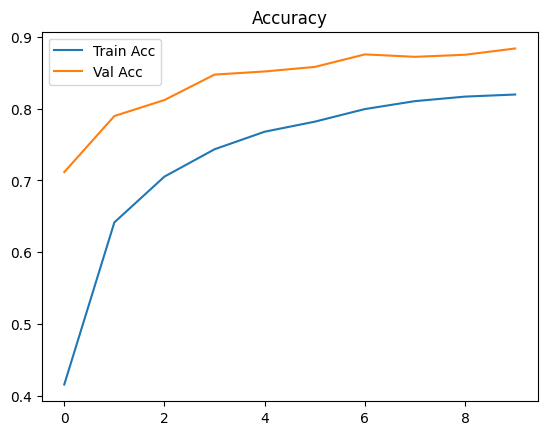

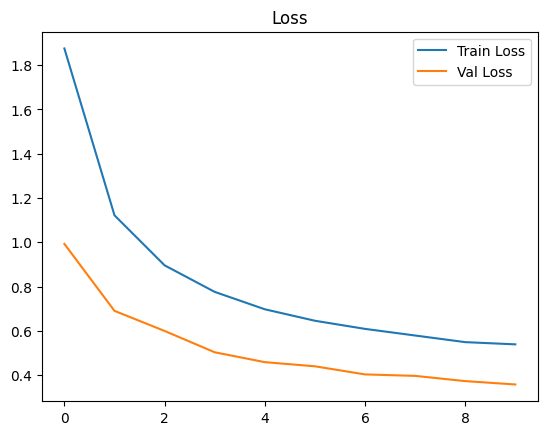

[RESULT] Validation Accuracy: 88.40%
[RESULT] Validation Loss: 0.3536
[CLASSIFICATION REPORT]
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.06      0.06      0.06       199
                     Pepper__bell___healthy       0.08      0.08      0.08       295
                      Potato___Early_blight       0.04      0.04      0.04       200
                       Potato___Late_blight       0.05      0.05      0.05       200
                           Potato___healthy       0.00      0.00      0.00        30
                      Tomato_Bacterial_spot       0.09      0.10      0.10       425
                        Tomato_Early_blight       0.07      0.05      0.06       200
                         Tomato_Late_blight       0.07      0.07      0.07       381
                           Tomato_Leaf_Mold       0.07      0.07      0.07       190
                  Tomato_Septoria_leaf_spot       0.07 

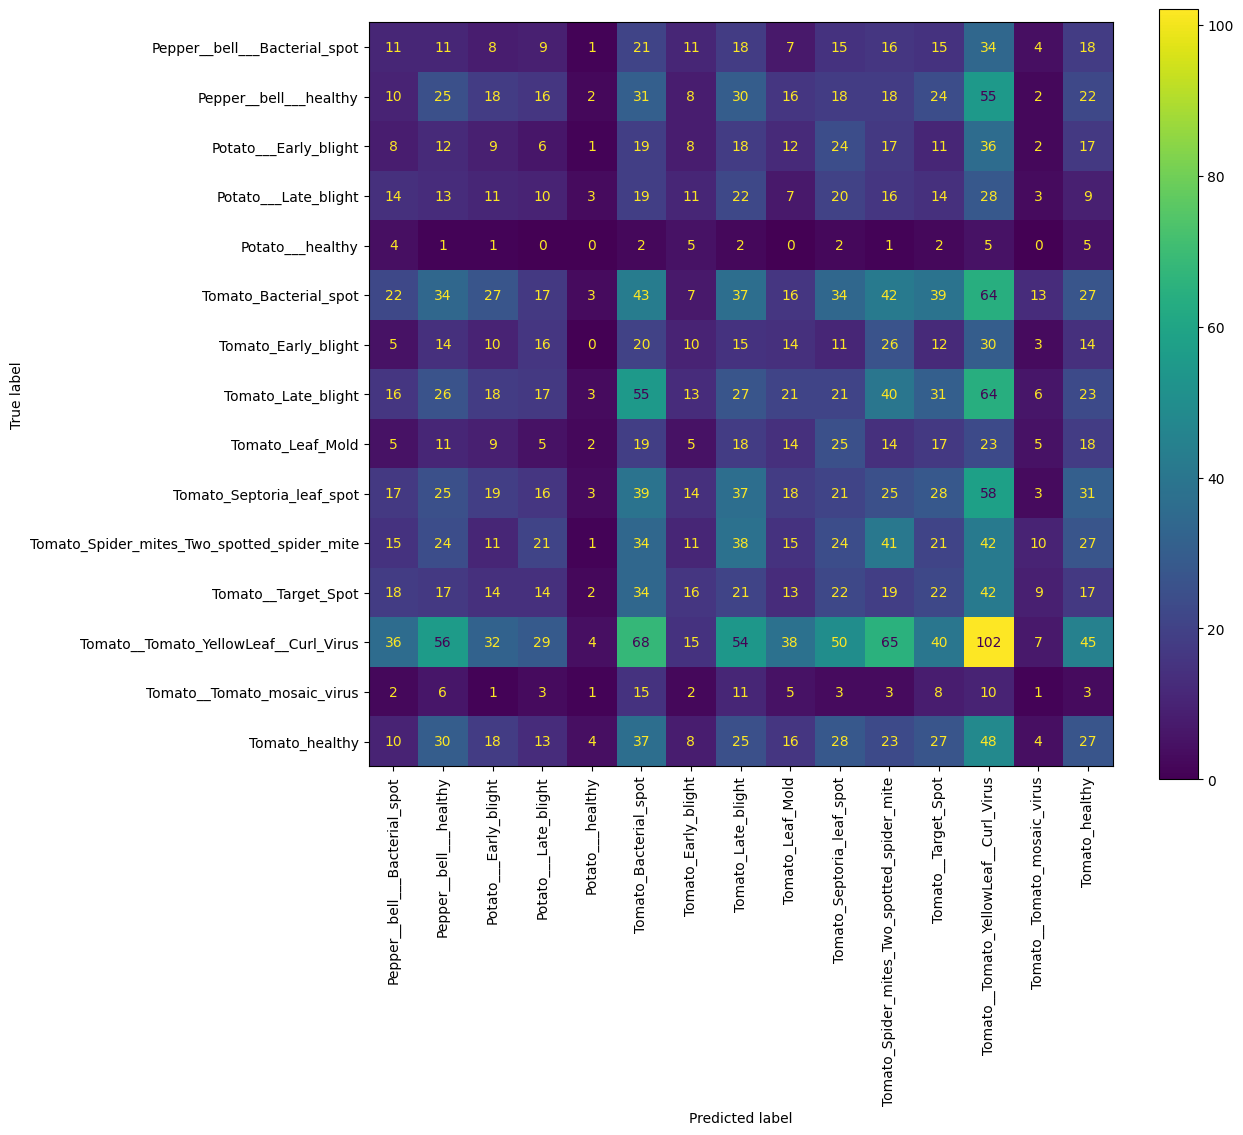

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import cv2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# === Constants ===
INIT_LR = 1e-4
EPOCHS = 10
BS = 32
IMG_SIZE = (224, 224)
DATASET_DIR = "./Plant Disease dataset/PlantVillage"

# === Data Augmentation ===
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BS,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BS,
    class_mode="categorical",
    subset="validation"
)

# === Save label map ===
label_map = train_gen.class_indices
with open("label_binarizer.pkl", "wb") as f:
    pickle.dump(label_map, f)

# === Build the Model ===
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
baseModel.trainable = False  # Freeze base

headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(len(train_gen.class_indices), activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

# === Compile ===
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# === Train ===
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

# === Save model ===
model.save("plant_disease_mobilenetv2.h5")

# === Plot Accuracy & Loss ===
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# === Evaluate ===
val_gen.reset()
loss, acc = model.evaluate(val_gen, verbose=0)
print(f"[RESULT] Validation Accuracy: {acc * 100:.2f}%")
print(f"[RESULT] Validation Loss: {loss:.4f}")

# === Classification Report ===
preds = model.predict(val_gen, verbose=0)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

print("[CLASSIFICATION REPORT]")
print(classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_gen.class_indices.keys())
disp.plot(ax=ax, xticks_rotation=90)
plt.show()
